In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler



import DataImport
import ProcessTrips

trips_import = ProcessTrips.transformTrips(DataImport.trips)
zones = DataImport.zones

Original number of rows: 6078437
Number of rows after removing outliers: 6078437
Number of rows after dropping NA values: 6078437


In [2]:
trips = trips_import.head(300000)

In [3]:
# Step 1: Select Columns Suitable for KNN (continuous and categorical)
knn_columns = [
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
    'tolls_amount', 'improvement_surcharge', 'trip_duration',
    'pickup_hour', 'PULocationID_encoded', 'DOLocationID_encoded', 'VendorID_encoded', #'total_amount', isimtas del multikolinearumo
]

# Filter the DataFrame
knn_data = trips[knn_columns]


# Check for zero values in 'trip_distance' and handle them
knn_data['fare_per_meter'] = knn_data['fare_amount'] / knn_data['trip_distance'].replace(0, np.nan)

# If you want to replace the NaN values with 0 or another value (optional):
knn_data['fare_per_meter'] = knn_data['fare_per_meter'].fillna(0)

# Display the result to ensure that there is no division by zero
print(knn_data[['fare_amount', 'trip_distance', 'fare_per_meter']].head())


   fare_amount  trip_distance  fare_per_meter
0          7.0            1.5        4.666667
1         14.0            2.6        5.384615
7          6.5            1.3        5.000000
8         13.5            3.7        3.648649
9         10.0            2.1        4.761905


C:\Users\Eimante\AppData\Local\Temp\ipykernel_30672\1016199034.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_data['fare_per_meter'] = knn_data['fare_amount'] / knn_data['trip_distance'].replace(0, np.nan)
C:\Users\Eimante\AppData\Local\Temp\ipykernel_30672\1016199034.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_data['fare_per_meter'] = knn_data['fare_per_meter'].fillna(0)


In [4]:
# Step 2: categorize trip duration into 5 categories based on quantiles

knn_data['trip_duration_class'] = pd.qcut(
    knn_data['trip_duration'], 
    q=5,  # Create 5 bins
    labels=[0, 1, 2, 3, 4]  # Assign class labels for the 5 bins
)
print(pd.qcut(knn_data['trip_duration'], q=5).value_counts())


trip_duration
(-0.001, 278.0]    60181
(588.0, 828.0]     60095
(278.0, 422.0]     60094
(828.0, 1936.0]    59898
(422.0, 588.0]     59732
Name: count, dtype: int64


C:\Users\Eimante\AppData\Local\Temp\ipykernel_30672\732483509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_data['trip_duration_class'] = pd.qcut(


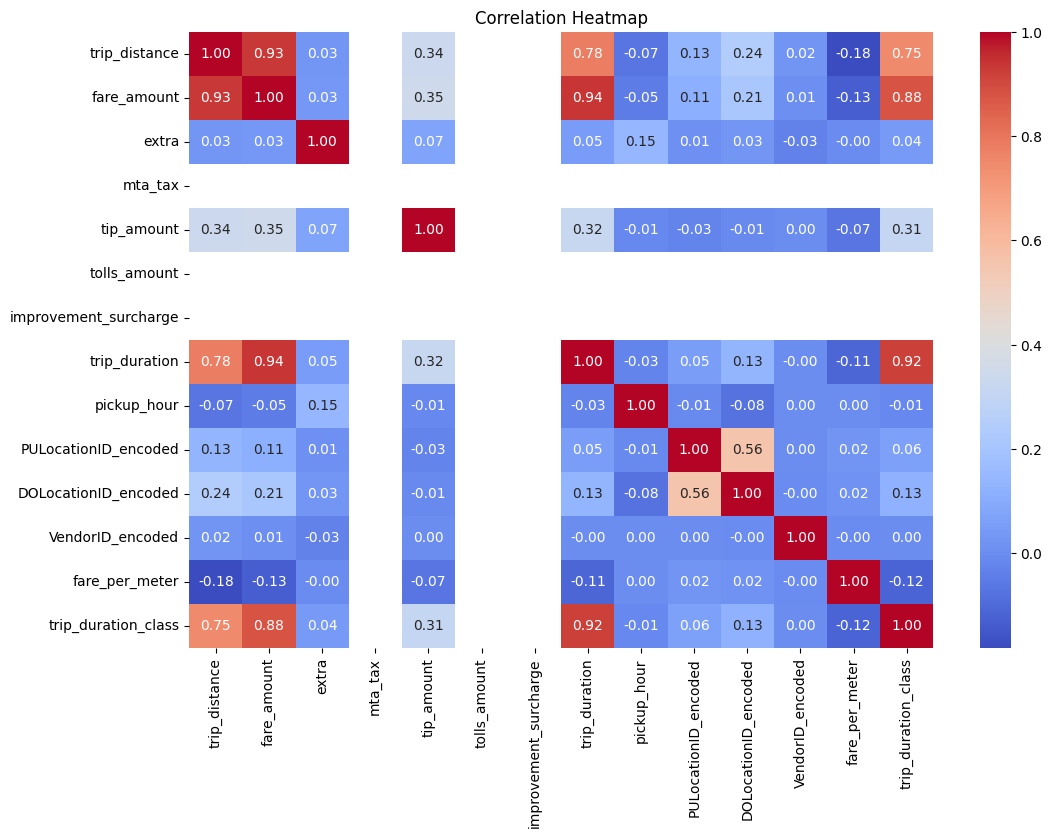

In [5]:
# Calculate the correlation matrix
corr_matrix = knn_data.corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Remove highly correlated features (e.g., if two features have correlation above 0.95)
# Based on the heatmap, choose which features to drop to avoid multicollinearity.


In [6]:
import pandas as pd

# Calculate the correlation matrix
corr_matrix = knn_data.corr()

# Create a mask to identify pairs of features with correlation > 0.8 or < -0.8
# We are using absolute value because we care about both positive and negative correlations
mask = (corr_matrix.abs() > 0.8) & (corr_matrix.abs() < 1)

# Find the columns that are highly correlated
highly_correlated_pairs = set()

for column in mask.columns:
    # For each column, find the pairs of columns that are highly correlated
    highly_correlated_pairs.update(mask[column][mask[column]].index)

# Remove the highly correlated features
columns_to_remove = list(highly_correlated_pairs)
columns_to_remove.remove('trip_duration_class')  # Don't remove the target variable

# Create a cleaned DataFrame without the highly correlated features
knn_data_cleaned = knn_data.drop(columns=columns_to_remove)

# Display the cleaned dataset and the columns that were removed
print(f"Removed Columns: {columns_to_remove}")
print(f"Cleaned DataFrame shape: {knn_data_cleaned.shape}")


Removed Columns: ['fare_amount', 'trip_distance', 'trip_duration']
Cleaned DataFrame shape: (300000, 11)


In [7]:
# Check for constant columns
constant_columns = knn_data_cleaned.columns[knn_data_cleaned.nunique() == 1]
print("Constant columns:", constant_columns)

# Optionally, remove constant columns from the data
knn_data_cleaned_2 = knn_data_cleaned.drop(columns=constant_columns)

Constant columns: Index(['mta_tax', 'tolls_amount', 'improvement_surcharge'], dtype='object')


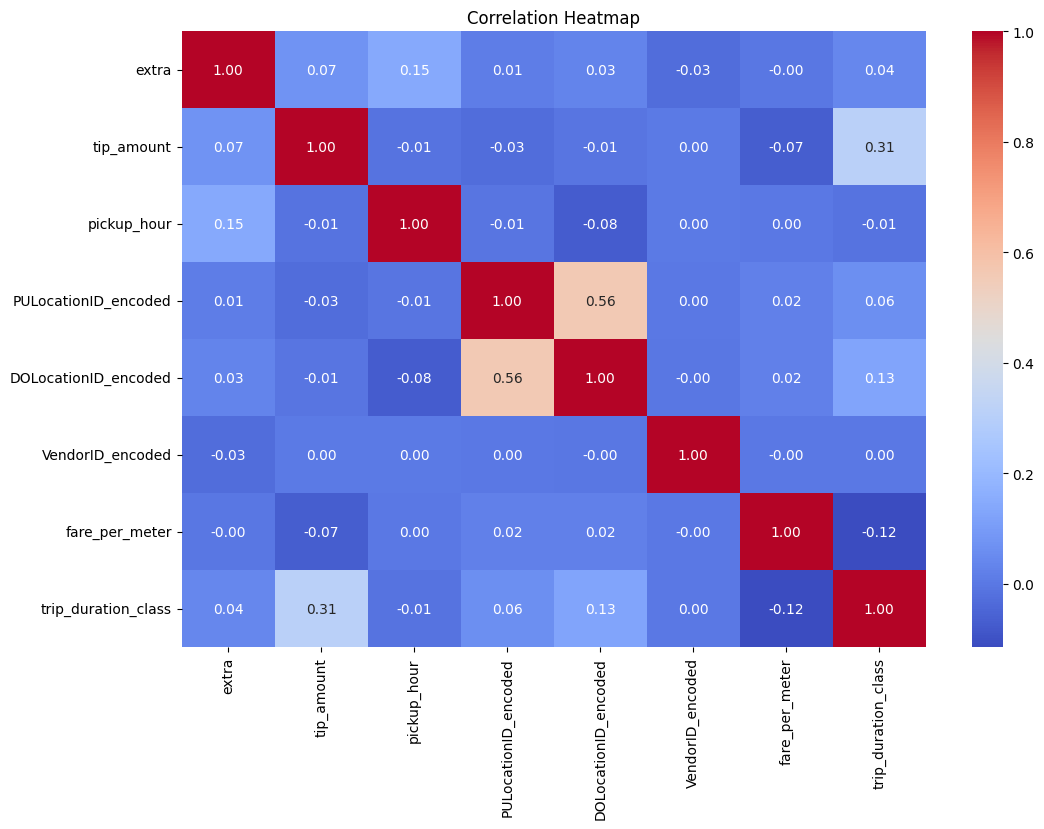

In [8]:
# Calculate the correlation matrix
corr_matrix_2 = knn_data_cleaned_2.corr()

# Plot the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Remove highly correlated features (e.g., if two features have correlation above 0.95)
# Based on the heatmap, choose which features to drop to avoid multicollinearity.


In [9]:
# Step 3: Prepare Features and Target Variable
X = knn_data.drop(columns=['trip_duration', 'trip_duration_class'])
y = knn_data['trip_duration_class']


In [10]:
# Step 4: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [12]:
# Calculate misclassification error for different k values
error_rate = []
# Iterate over a range of k values
k_range = range(1, 30)  # Try k from 1 to 30
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    # Calculate misclassification error
    error = np.mean(y_pred_k != y_test)
    error_rate.append(error)

The optimal k value is: 13


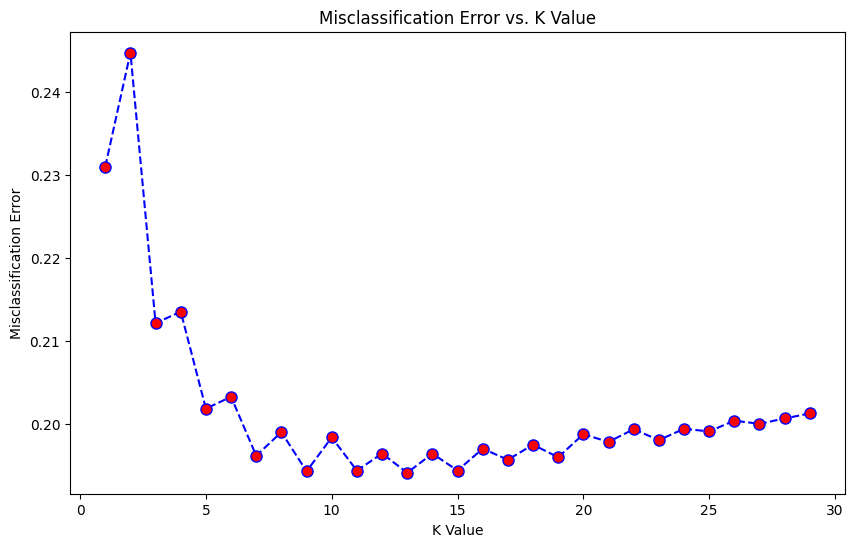

In [13]:
# Find the optimal k value
optimal_k = k_range[np.argmin(error_rate)]
print(f"The optimal k value is: {optimal_k}")

# Plot the misclassification error
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=8)
plt.title('Misclassification Error vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Misclassification Error')
plt.show()

In [14]:
# # Fit KNN with the optimal k
knn = KNeighborsClassifier(n_neighbors=optimal_k)  
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

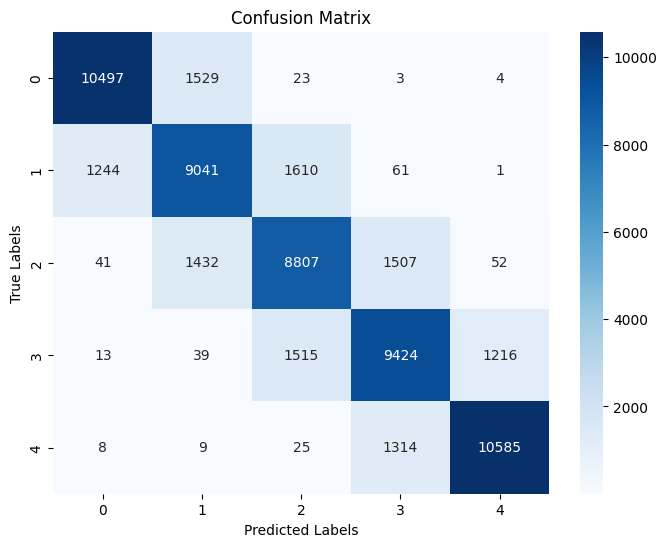

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12056
           1       0.75      0.76      0.75     11957
           2       0.74      0.74      0.74     11839
           3       0.77      0.77      0.77     12207
           4       0.89      0.89      0.89     11941

    accuracy                           0.81     60000
   macro avg       0.81      0.81      0.81     60000
weighted avg       0.81      0.81      0.81     60000



In [15]:
# Predict on the test data
y_pred = knn.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [16]:
# Step 3: Print Misclassifications
misclassifications = sum(y_test != y_pred)
print(f"Total misclassifications: {misclassifications} out of {len(y_test)}")


Total misclassifications: 11646 out of 60000


In [18]:

# True label for the first sample in the test set
true_label = y_test.iloc[0]  # y_test is a pandas Series, so use .iloc for indexing

# Print the true label (trip_duration_class) for the first test sample
print(f"True label (category) for the given input is: {true_label}")

# Get the first sample from the scaled X_test (actual feature values)
actual_input = X_test[0]

# Reshape the input for prediction (KNN expects 2D input)
example_input = actual_input.reshape(1, -1)

# Make a prediction using the trained model
example_prediction = knn.predict(example_input)

# Print the predicted category (trip_duration_class)
print(f"Predicted trip duration category for the given input is: {example_prediction[0]}")


True label (category) for the given input is: 4
Predicted trip duration category for the given input is: 4
